In [1]:
# This notebook illustrates example outputs from Funman, and how to work with the ParameterSpace object it creates.

# The file scratch/hackathon/hackathon_fall_2023_demo_terarrium.py was used to generate the outputs rendered here.

SAVED_RESULTS_DIR = "./out"

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools
from funman import FunmanWorkRequest, EncodingSchedule

import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
from funman import FUNMANConfig
import logging
from funman_demo import summarize_results



RESOURCES = "../resources"
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "terrarium-tests")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR,"seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "seird_request.json"
)


# EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "stratified")
# MODEL_PATH = os.path.join(
#     EXAMPLE_DIR,"model_amr.json"
# )
# REQUEST_PATH = os.path.join(
#     EXAMPLE_DIR, "model_amr_request.json"
# )


# %load_ext autoreload
# %autoreload 2

In [32]:
# Feb 2024 Hackathon Scenario 3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request.json"
)


N = "Total_population"
STATES = ["Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]
COMPARTMENTS = STATES + [N]

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, 60, 10)))

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001

    factor = 0.5
    to_synthesize = ["beta", "gamma"]
    for p in [po for po in funman_request.parameters if po.name not in []]:
        param = funman_request.parameter(p.name)
        param.interval.lb = p.interval.lb-factor
        param.interval.ub = p.interval.ub+factor
        param.label = "all" if p.name in to_synthesize else "any"

    # # Susceptible is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    # c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["Susceptible"], timepoints=Interval(lb=0), derivative=True)
    # funman_request.constraints.append(c1)

    # # # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    # c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["Recovered"], weights=[-1], derivative=True)
    # funman_request.constraints.append(c2)

    # # # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    # c3 = LinearConstraint(name="c3", additive_bounds=Interval(ub=0), variables=["Deceased"], weights=[-1], derivative=True, timepoints=Interval(lb=0))
    # funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    # Infected peak
    c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=50), variables=["Infected"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    

    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population")
    print(summary)

2024-02-28 19:21:34,510 - funman.server.worker - INFO - FunmanWorker running...
2024-02-28 19:21:34,514 - funman.server.worker - INFO - Starting work on: 2e7685fa-c18e-4b46-8494-91e16a079692
2024-02-28 19:21:36,521 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_0_57.smt2
Saving smtlib file: ./out/box_search_0_58.smt2
Saving smtlib file: ./out/box_search_0_59.smt2
Saving smtlib file: ./out/box_search_0_60.smt2
Saving smtlib file: ./out/box_search_0_61.smt2
Saving smtlib file: ./out/box_search_0_62.smt2


2024-02-28 19:21:45,661 - funman.search.box_search - INFO - progress: 0.16667


Saving smtlib file: ./out/box_search_0_63.smt2
Saving smtlib file: ./out/box_search_1_10.smt2


2024-02-28 19:21:45,954 - funman.search.box_search - INFO - progress: 0.33333


Saving smtlib file: ./out/box_search_2_10.smt2


2024-02-28 19:21:46,426 - funman.search.box_search - INFO - progress: 0.50000
2024-02-28 19:21:46,755 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_3_8.smt2


2024-02-28 19:21:47,292 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_4_12.smt2


2024-02-28 19:21:48,081 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(0.3330000000000001, 0.7696856706346358)][(0.7696856706346358, 1.3330000000000002)])
2024-02-28 19:21:48,082 - funman.representation.box - INFO - widths: 1.00000 -> 1.00000 1.00000 (raw), 1.00000 -> 1.00000 1.00000 (norm)
2024-02-28 19:21:48,086 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_5_8.smt2


2024-02-28 19:21:48,390 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(0.7696856706346358, 1.1877819632736972)][(1.1877819632736972, 1.3330000000000002)])
2024-02-28 19:21:48,391 - funman.representation.box - INFO - widths: 1.00000 -> 1.00000 1.00000 (raw), 1.00000 -> 1.00000 1.00000 (norm)
2024-02-28 19:21:48,395 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_6_11.smt2


2024-02-28 19:21:48,712 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(-0.375, 0.125)][(0.125, 0.625)])
2024-02-28 19:21:48,713 - funman.representation.box - INFO - widths: 1.00000 -> 0.50000 1.00000 (raw), 1.00000 -> 0.50000 0.50000 (norm)
2024-02-28 19:21:48,718 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:21:48,737 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(-0.375, -0.125)][(-0.125, 0.125)])
2024-02-28 19:21:48,738 - funman.representation.box - INFO - widths: 0.50000 -> 0.41810 1.00000 (raw), 0.50000 -> 0.41810 0.41810 (norm)
2024-02-28 19:21:48,742 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:21:48,763 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(0.7696856706346358, 0.9787338169541665)][(0.9787338169541665, 1.1877819632736972)])
2024-02-28 19:21:48,764 - funman.representation.box - INFO - widths: 0.41810 -> 0.25000 1.00000 (raw), 0.41810 -> 0.25000 0.25000 (norm)


Saving smtlib file: ./out/box_search_9_9.smt2


2024-02-28 19:21:49,093 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(-0.125, 0.0)][(0.0, 0.125)])
2024-02-28 19:21:49,094 - funman.representation.box - INFO - widths: 0.25000 -> 0.20905 1.00000 (raw), 0.25000 -> 0.20905 0.20905 (norm)
2024-02-28 19:21:49,098 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:21:49,118 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(0.9787338169541665, 1.083257890113932)][(1.083257890113932, 1.1877819632736972)])
2024-02-28 19:21:49,120 - funman.representation.box - INFO - widths: 0.20905 -> 0.12500 1.00000 (raw), 0.20905 -> 0.12500 0.12500 (norm)
2024-02-28 19:21:49,124 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_11_4.smt2


2024-02-28 19:21:49,447 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.0625)][(0.0625, 0.125)])
2024-02-28 19:21:49,449 - funman.representation.box - INFO - widths: 0.12500 -> 0.10452 1.00000 (raw), 0.12500 -> 0.10452 0.10452 (norm)
2024-02-28 19:21:49,454 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:21:49,477 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.1355199266938147)][(1.1355199266938147, 1.1877819632736972)])
2024-02-28 19:21:49,478 - funman.representation.box - INFO - widths: 0.10452 -> 0.06250 1.00000 (raw), 0.10452 -> 0.06250 0.06250 (norm)
2024-02-28 19:21:49,482 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:21:49,503 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.03125)][(0.03125, 0.0625)])
2024-02-28 19:21:49,505 - funman.representation.box - INFO - widths: 0.06250 -> 0.05226 1.00000 (raw), 0.06250 -> 0.05226 0.05226 (norm)
20

Saving smtlib file: ./out/box_search_14_4.smt2
Saving smtlib file: ./out/box_search_14_5.smt2


2024-02-28 19:21:51,235 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.1093889084038735)][(1.1093889084038735, 1.1355199266938147)])
2024-02-28 19:21:51,237 - funman.representation.box - INFO - widths: 0.05226 -> 0.03125 1.00000 (raw), 0.05226 -> 0.03125 0.03125 (norm)
2024-02-28 19:21:51,240 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_15_4.smt2


2024-02-28 19:21:51,769 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.1093889084038735)][(1.1093889084038735, 1.1355199266938147)])
2024-02-28 19:21:51,769 - funman.representation.box - INFO - widths: 0.05226 -> 0.03125 1.00000 (raw), 0.05226 -> 0.03125 0.03125 (norm)
2024-02-28 19:21:51,773 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_16_6.smt2


2024-02-28 19:21:58,859 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_16_7.smt2


2024-02-28 19:21:59,299 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.03125, 0.046875)][(0.046875, 0.0625)])
2024-02-28 19:21:59,300 - funman.representation.box - INFO - widths: 0.03125 -> 0.02613 1.00000 (raw), 0.03125 -> 0.02613 0.02613 (norm)
2024-02-28 19:21:59,303 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_17_5.smt2


2024-02-28 19:22:02,191 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.015625)][(0.015625, 0.03125)])
2024-02-28 19:22:02,191 - funman.representation.box - INFO - widths: 0.03125 -> 0.02613 1.00000 (raw), 0.03125 -> 0.02613 0.02613 (norm)
2024-02-28 19:22:02,195 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_18_6.smt2
Saving smtlib file: ./out/box_search_18_7.smt2


2024-02-28 19:22:04,627 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.015625)][(0.015625, 0.03125)])
2024-02-28 19:22:04,628 - funman.representation.box - INFO - widths: 0.03125 -> 0.02613 1.00000 (raw), 0.03125 -> 0.02613 0.02613 (norm)
2024-02-28 19:22:04,631 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_19_6.smt2


2024-02-28 19:22:04,946 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.0963233992589028)][(1.0963233992589028, 1.1093889084038735)])
2024-02-28 19:22:04,947 - funman.representation.box - INFO - widths: 0.02613 -> 0.01562 1.00000 (raw), 0.02613 -> 0.01562 0.01562 (norm)
2024-02-28 19:22:04,950 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_20_5.smt2


2024-02-28 19:22:05,198 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.0078125)][(0.0078125, 0.015625)])
2024-02-28 19:22:05,199 - funman.representation.box - INFO - widths: 0.01562 -> 0.01307 1.00000 (raw), 0.01562 -> 0.01307 0.01307 (norm)
2024-02-28 19:22:05,202 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_21_6.smt2


2024-02-28 19:22:05,608 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.0897906446864174)][(1.0897906446864174, 1.0963233992589028)])
2024-02-28 19:22:05,609 - funman.representation.box - INFO - widths: 0.01307 -> 0.00781 1.00000 (raw), 0.01307 -> 0.00781 0.00781 (norm)
2024-02-28 19:22:05,612 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_22_3.smt2


2024-02-28 19:22:06,034 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.00390625)][(0.00390625, 0.0078125)])
2024-02-28 19:22:06,035 - funman.representation.box - INFO - widths: 0.00781 -> 0.00653 1.00000 (raw), 0.00781 -> 0.00653 0.00653 (norm)
2024-02-28 19:22:06,039 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_23_2.smt2


2024-02-28 19:22:06,642 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.0963233992589028)][(1.0963233992589028, 1.1093889084038735)])
2024-02-28 19:22:06,643 - funman.representation.box - INFO - widths: 0.02613 -> 0.01562 1.00000 (raw), 0.02613 -> 0.01562 0.01562 (norm)
2024-02-28 19:22:06,647 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:22:06,667 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.046875, 0.0546875)][(0.0546875, 0.0625)])
2024-02-28 19:22:06,668 - funman.representation.box - INFO - widths: 0.01562 -> 0.01307 1.00000 (raw), 0.01562 -> 0.01307 0.01307 (norm)
2024-02-28 19:22:06,671 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_25_2.smt2


2024-02-28 19:22:07,025 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.0963233992589028, 1.1028561538313881)][(1.1028561538313881, 1.1093889084038735)])
2024-02-28 19:22:07,027 - funman.representation.box - INFO - widths: 0.01307 -> 0.00781 1.00000 (raw), 0.01307 -> 0.00781 0.00781 (norm)
2024-02-28 19:22:07,031 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_26_2.smt2


2024-02-28 19:22:07,499 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.046875, 0.05078125)][(0.05078125, 0.0546875)])
2024-02-28 19:22:07,500 - funman.representation.box - INFO - widths: 0.00781 -> 0.00653 1.00000 (raw), 0.00781 -> 0.00653 0.00653 (norm)
2024-02-28 19:22:07,503 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_27_2.smt2


2024-02-28 19:22:25,140 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1093889084038735, 1.1224544175488442)][(1.1224544175488442, 1.1355199266938147)])
2024-02-28 19:22:25,140 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json
2024-02-28 19:22:25,141 - funman.representation.box - INFO - widths: 0.02613 -> 0.01562 1.00000 (raw), 0.02613 -> 0.01562 0.01562 (norm)
2024-02-28 19:22:25,146 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_28_4.smt2


2024-02-28 19:22:30,380 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1028561538313881, 1.1061225311176308)][(1.1061225311176308, 1.1093889084038735)])
2024-02-28 19:22:30,382 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:22:30,385 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_29_4.smt2
Saving smtlib file: ./out/box_search_29_5.smt2


2024-02-28 19:22:31,606 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.0078125)][(0.0078125, 0.015625)])
2024-02-28 19:22:31,608 - funman.representation.box - INFO - widths: 0.01562 -> 0.01307 1.00000 (raw), 0.01562 -> 0.01307 0.01307 (norm)
2024-02-28 19:22:31,612 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:22:31,634 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1224544175488442, 1.1289871721213296)][(1.1289871721213296, 1.1355199266938147)])
2024-02-28 19:22:31,636 - funman.representation.box - INFO - widths: 0.01307 -> 0.00781 1.00000 (raw), 0.01307 -> 0.00781 0.00781 (norm)
2024-02-28 19:22:31,639 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_31_2.smt2


2024-02-28 19:22:48,582 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json
2024-02-28 19:22:48,594 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.0078125)][(0.0078125, 0.015625)])
2024-02-28 19:22:48,595 - funman.representation.box - INFO - widths: 0.01562 -> 0.01307 1.00000 (raw), 0.01562 -> 0.01307 0.01307 (norm)
2024-02-28 19:22:48,598 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_32_2.smt2


2024-02-28 19:23:03,720 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json
2024-02-28 19:23:03,731 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.046875, 0.048828125)][(0.048828125, 0.05078125)])
2024-02-28 19:23:03,732 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:23:03,738 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_33_2.smt2


2024-02-28 19:23:05,822 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0078125, 0.01171875)][(0.01171875, 0.015625)])
2024-02-28 19:23:05,825 - funman.representation.box - INFO - widths: 0.00781 -> 0.00653 1.00000 (raw), 0.00781 -> 0.00653 0.00653 (norm)
2024-02-28 19:23:05,830 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:05,856 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1224544175488442, 1.125720794835087)][(1.125720794835087, 1.1289871721213296)])
2024-02-28 19:23:05,857 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:23:05,861 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_35_4.smt2
Saving smtlib file: ./out/box_search_35_5.smt2


2024-02-28 19:23:07,218 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1093889084038735, 1.1159216629763589)][(1.1159216629763589, 1.1224544175488442)])
2024-02-28 19:23:07,220 - funman.representation.box - INFO - widths: 0.01307 -> 0.00781 1.00000 (raw), 0.01307 -> 0.00781 0.00781 (norm)
2024-02-28 19:23:07,223 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_36_4.smt2


2024-02-28 19:23:09,385 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1093889084038735, 1.1159216629763589)][(1.1159216629763589, 1.1224544175488442)])
2024-02-28 19:23:09,385 - funman.representation.box - INFO - widths: 0.01307 -> 0.00781 1.00000 (raw), 0.01307 -> 0.00781 0.00781 (norm)
2024-02-28 19:23:09,388 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:09,407 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0, 0.00390625)][(0.00390625, 0.0078125)])
2024-02-28 19:23:09,408 - funman.representation.box - INFO - widths: 0.00781 -> 0.00653 1.00000 (raw), 0.00781 -> 0.00653 0.00653 (norm)
2024-02-28 19:23:09,411 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_38_0.smt2


2024-02-28 19:23:10,414 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1159216629763589, 1.1191880402626015)][(1.1191880402626015, 1.1224544175488442)])
2024-02-28 19:23:10,415 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:23:10,418 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_39_0.smt2


2024-02-28 19:23:11,395 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.00390625, 0.005859375)][(0.005859375, 0.0078125)])
2024-02-28 19:23:11,397 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:23:11,400 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:30,926 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_40_0.smt2
Saving smtlib file: ./out/box_search_40_1.smt2


2024-02-28 19:23:32,891 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0078125, 0.01171875)][(0.01171875, 0.015625)])
2024-02-28 19:23:32,893 - funman.representation.box - INFO - widths: 0.00781 -> 0.00653 1.00000 (raw), 0.00781 -> 0.00653 0.00653 (norm)
2024-02-28 19:23:32,896 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_41_0.smt2


2024-02-28 19:23:33,146 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1093889084038735, 1.1126552856901162)][(1.1126552856901162, 1.1159216629763589)])
2024-02-28 19:23:33,147 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:23:33,152 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:33,172 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.0078125, 0.009765625)][(0.009765625, 0.01171875)])
2024-02-28 19:23:33,174 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:23:33,177 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:33,198 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1126552856901162, 1.1142884743332375)][(1.1142884743332375, 1.1159216629763589)])
2024-02-28 19:23:33,199 - funman.representation.box - INFO - widths: 

Saving smtlib file: ./out/box_search_46_0.smt2


2024-02-28 19:23:45,441 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_46_1.smt2


2024-02-28 19:23:47,256 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.0865242674001747)][(1.0865242674001747, 1.0897906446864174)])
2024-02-28 19:23:47,257 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:23:47,260 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:55,513 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json


Saving smtlib file: ./out/box_search_47_0.smt2
Saving smtlib file: ./out/box_search_47_1.smt2


2024-02-28 19:23:56,761 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1159216629763589, 1.1175548516194802)][(1.1175548516194802, 1.1191880402626015)])
2024-02-28 19:23:56,763 - funman.representation.box - INFO - widths: 0.00327 -> 0.00195 1.00000 (raw), 0.00327 -> 0.00195 0.00195 (norm)
2024-02-28 19:23:56,766 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:56,786 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.00390625, 0.0048828125)][(0.0048828125, 0.005859375)])
2024-02-28 19:23:56,787 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:23:56,791 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_49_0.smt2


2024-02-28 19:23:57,294 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1175548516194802, 1.118371445941041)][(1.118371445941041, 1.1191880402626015)])
2024-02-28 19:23:57,295 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:23:57,299 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_50_0.smt2
Saving smtlib file: ./out/box_search_50_1.smt2


2024-02-28 19:23:58,533 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1028561538313881, 1.1061225311176308)][(1.1061225311176308, 1.1093889084038735)])
2024-02-28 19:23:58,534 - funman.representation.box - INFO - widths: 0.00653 -> 0.00391 1.00000 (raw), 0.00653 -> 0.00391 0.00391 (norm)
2024-02-28 19:23:58,537 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:23:58,556 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.05078125, 0.052734375)][(0.052734375, 0.0546875)])
2024-02-28 19:23:58,557 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:23:58,560 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_52_0.smt2
Saving smtlib file: ./out/box_search_52_1.smt2


2024-02-28 19:24:01,366 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.00390625, 0.005859375)][(0.005859375, 0.0078125)])
2024-02-28 19:24:01,367 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:24:01,370 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_53_0.smt2


2024-02-28 19:24:09,375 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json
2024-02-28 19:24:09,385 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.00390625, 0.005859375)][(0.005859375, 0.0078125)])
2024-02-28 19:24:09,386 - funman.representation.box - INFO - widths: 0.00391 -> 0.00327 1.00000 (raw), 0.00391 -> 0.00327 0.00327 (norm)
2024-02-28 19:24:09,389 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_54_0.smt2


2024-02-28 19:24:10,072 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.083257890113932, 1.0848910787570534)][(1.0848910787570534, 1.0865242674001747)])
2024-02-28 19:24:10,073 - funman.representation.box - INFO - widths: 0.00327 -> 0.00195 1.00000 (raw), 0.00327 -> 0.00195 0.00195 (norm)
2024-02-28 19:24:10,077 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_55_0.smt2


2024-02-28 19:24:10,725 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.005859375, 0.0068359375)][(0.0068359375, 0.0078125)])
2024-02-28 19:24:10,726 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:10,729 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_56_0.smt2


2024-02-28 19:24:12,971 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.0848910787570534, 1.0857076730786142)][(1.0857076730786142, 1.0865242674001747)])
2024-02-28 19:24:12,972 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:12,976 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_57_0.smt2
Saving smtlib file: ./out/box_search_57_1.smt2


2024-02-28 19:24:13,633 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1061225311176308, 1.1077557197607522)][(1.1077557197607522, 1.1093889084038735)])
2024-02-28 19:24:13,634 - funman.representation.box - INFO - widths: 0.00327 -> 0.00195 1.00000 (raw), 0.00327 -> 0.00195 0.00195 (norm)
2024-02-28 19:24:13,638 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_58_0.smt2


2024-02-28 19:24:14,062 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1061225311176308, 1.1077557197607522)][(1.1077557197607522, 1.1093889084038735)])
2024-02-28 19:24:14,063 - funman.representation.box - INFO - widths: 0.00327 -> 0.00195 1.00000 (raw), 0.00327 -> 0.00195 0.00195 (norm)
2024-02-28 19:24:14,070 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_59_0.smt2


2024-02-28 19:24:14,681 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.052734375, 0.0537109375)][(0.0537109375, 0.0546875)])
2024-02-28 19:24:14,684 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:14,689 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_60_0.smt2
Saving smtlib file: ./out/box_search_60_1.smt2


2024-02-28 19:24:15,340 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.052734375, 0.0537109375)][(0.0537109375, 0.0546875)])
2024-02-28 19:24:15,342 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:15,346 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_61_0.smt2


2024-02-28 19:24:15,625 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.05078125, 0.0517578125)][(0.0517578125, 0.052734375)])
2024-02-28 19:24:15,626 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:15,630 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_62_0.smt2
Saving smtlib file: ./out/box_search_62_1.smt2


2024-02-28 19:24:16,762 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.05078125, 0.0517578125)][(0.0517578125, 0.052734375)])
2024-02-28 19:24:16,764 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:16,768 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_63_0.smt2


2024-02-28 19:24:17,003 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1061225311176308, 1.1069391254391916)][(1.1069391254391916, 1.1077557197607522)])
2024-02-28 19:24:17,005 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:17,010 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_64_0.smt2
Saving smtlib file: ./out/box_search_64_1.smt2


2024-02-28 19:24:17,611 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1077557197607522, 1.108572314082313)][(1.108572314082313, 1.1093889084038735)])
2024-02-28 19:24:17,612 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:17,615 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_65_0.smt2


2024-02-28 19:24:18,207 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1061225311176308, 1.1069391254391916)][(1.1069391254391916, 1.1077557197607522)])
2024-02-28 19:24:18,208 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:18,211 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_66_0.smt2
Saving smtlib file: ./out/box_search_66_1.smt2


2024-02-28 19:24:19,003 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1077557197607522, 1.108572314082313)][(1.108572314082313, 1.1093889084038735)])
2024-02-28 19:24:19,004 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:19,007 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_67_0.smt2


2024-02-28 19:24:19,488 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1077557197607522, 1.108572314082313)][(1.108572314082313, 1.1093889084038735)])
2024-02-28 19:24:19,488 - funman.api.run - INFO - Dumping results to ./out/2e7685fa-c18e-4b46-8494-91e16a079692.json
2024-02-28 19:24:19,490 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:19,498 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_68_0.smt2


2024-02-28 19:24:20,516 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1077557197607522, 1.108572314082313)][(1.108572314082313, 1.1093889084038735)])
2024-02-28 19:24:20,518 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:20,523 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_69_0.smt2
Saving smtlib file: ./out/box_search_69_1.smt2


2024-02-28 19:24:21,192 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.1061225311176308, 1.1069391254391916)][(1.1069391254391916, 1.1077557197607522)])
2024-02-28 19:24:21,193 - funman.representation.box - INFO - widths: 0.00163 -> 0.00098 1.00000 (raw), 0.00163 -> 0.00098 0.00098 (norm)
2024-02-28 19:24:21,198 - funman.search.box_search - INFO - progress: 0.66667


Saving smtlib file: ./out/box_search_70_0.smt2
Saving smtlib file: ./out/box_search_70_1.smt2


2024-02-28 19:24:25,558 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.0865242674001747, 1.088157456043296)][(1.088157456043296, 1.0897906446864174)])
2024-02-28 19:24:25,559 - funman.representation.box - INFO - widths: 0.00327 -> 0.00195 1.00000 (raw), 0.00327 -> 0.00195 0.00195 (norm)
2024-02-28 19:24:25,564 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:24:25,585 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](gamma[(0.005859375, 0.0068359375)][(0.0068359375, 0.0078125)])
2024-02-28 19:24:25,586 - funman.representation.box - INFO - widths: 0.00195 -> 0.00163 1.00000 (raw), 0.00195 -> 0.00163 0.00163 (norm)
2024-02-28 19:24:25,589 - funman.search.box_search - INFO - progress: 0.66667
2024-02-28 19:24:25,610 - funman.representation.box - INFO - Split[[4.00000, 5.00000]](beta[(1.0865242674001747, 1.0873408617217355)][(1.0873408617217355, 1.088157456043296)])
2024-02-28 19:24:25,611 - funman.representation.box - INFO - widths: 

<Axes: xlabel='time'>

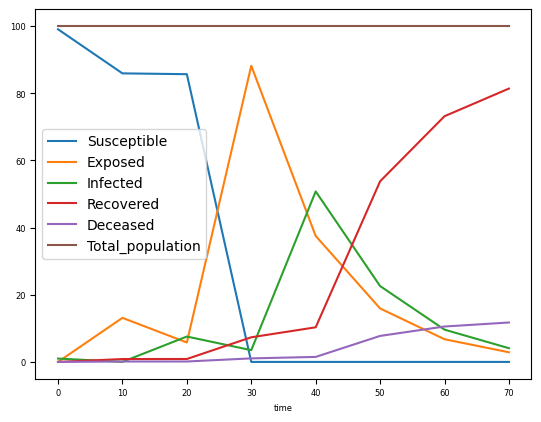

In [19]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[COMPARTMENTS].plot()


In [10]:
import textwrap
expr = results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression
print(textwrap.fill(expr, 80))


((((((((((((((((((((assume_compartment & disj10) & (alpha =
30000000000000001/5000000000000000000)) & (gamma = 1/8)) & (epsilon =
8333333333333333/25000000000000000)) & (beta =
10412500000000001/12500000000000000)) & (Total_population_0 = 100.0)) &
(Total_population_1 = Total_population_0)) & (Infected_0 = 1.0)) & (Deceased_0 =
0.0)) & (Deceased_1 = (Deceased_0 - (alpha * Infected_0)))) & (Recovered_0 =
0.0)) & (Recovered_1 = (Recovered_0 - (gamma * Infected_0)))) & (Susceptible_0 =
99.0)) & (Exposed_0 = 0.0)) & (Exposed_1 = ((Exposed_0 + (epsilon * Exposed_0))
- (((beta * (Total_population_0 ^ -1.0)) * Infected_0) * Susceptible_0)))) &
(Infected_1 = (((Infected_0 - (alpha * Infected_0)) - (gamma * Infected_0)) +
(epsilon * Exposed_0)))) & (Susceptible_1 = (Susceptible_0 - (((beta *
(Total_population_0 ^ -1.0)) * Infected_0) * Susceptible_0)))) & ((conj12 | (!
assume_compartment)) | (! disj10))) & (((((((((((((((((((((((-1.0 *
Total_population_1) + Deceased_1) + Recovered_1) + Exposed_

In [ ]:
# SEIRHD

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0, 1])

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"

    for p in [po.name for po in funman_request.parameters if po.name not in ["S0", "I0", "E0", "R0", "H0", "D0", "N", "beta"]]:
    #["beta", "r_H_to_D", "r_E_to_I", "p_I_to_R", "r_I_to_R",  "p_I_to_H", "r_I_to_H", "p_H_to_R", "r_H_to_R","p_H_to_D","r_H_to_D"]:
        param = funman_request.parameter(p)
        param.interval.lb = 0
        param.interval.ub = 1

    # S is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["S"], derivative=True)
    funman_request.constraints.append(c1)

    # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["R"], weights=[-1], derivative=True)
    funman_request.constraints.append(c2)

    # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["D"], derivative=True)
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=["S", "E", "I", "R", "D", "H", "N"], weights=[1, 1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    funman_request.constraints.append(StateVariableConstraint(name="SB", variable="S", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="EB", variable="E", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="IB", variable="I", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="RB", variable="R", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="DB", variable="D", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="HB", variable="H", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(["S", "E", "I", "R", "H", "D"], results_unconstrained_point, ylabel="Population")
    print(summary)

In [9]:
json.loads(c2.model_dump_json())

{'soft': True,
 'name': 'c2',
 'timepoints': None,
 'additive_bounds': {'lb': -1.7976931348623157e+308,
  'ub': 0.0,
  'closed_upper_bound': False,
  'original_width': 1.7976931348623157e+308},
 'variables': ['R'],
 'weights': [-1],
 'derivative': True}

In [ ]:
import json
json.loads(results_unconstrained_point.parameter_space.false_boxes[0].explanation.model_dump_json())#['relevant_assumptions']

In [ ]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[["S", "E", "I", "R", "H", "D"]]
# df["S"]+df["E"]+df["I"]+df["D"]

In [ ]:
# Stratified

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0,1, 2])
    funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
#     funman_request.config.use_compartmental_constraints=False
#     r_H_to_D = funman_request.parameter("r_H_to_D")
#     r_H_to_D.interval.lb = 0
#     r_H_to_D.interval.ub = 1.0

    # r_E_to_I = funman_request.parameter("r_E_to_I")
    # r_E_to_I.interval.lb = 0
    # r_E_to_I.interval.ub = 1.0


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    # summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    # print(summary)

In [ ]:
results_unconstrained_point.parameter_space.points()[0]